<a href="https://colab.research.google.com/github/jesolisp/Fractional_Numerical_Methods/blob/main/01_Metodo_Euler_fraccionario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![logo_pagina.png](logo_pagina.png "Cálculo fraccionario, difusión y +")

In [ ]:
# Librerias necesarias
import time
import math
import numpy as np
from utils.mittag_leffler import ml
from numba import jit, prange
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 300
%matplotlib inline

# Método de Euler Fraccionario
En este cuaderno vamos a presentar la solución numérica a problemas de valor inicial. Para ello, consideramos la siguiente ecuación diferencial ordinaria fraccionaria

\begin{equation}
 \label{fode}
 {}^{*}_{0}\mathcal{D}_{t}^{\alpha}~ y(t) = f\left(t,y(t) \right), \quad m-1 < \alpha < m,
\end{equation}

\begin{equation}
 y^{j}(0) = y_{0}^{j}, \quad j = 0,1,\dots,n-1.
\end{equation}

Considerando que \eqref{fode} tiene una solución única $f(t)$ y que $f(t,y(t))$ satisface algunas condiciones suaves, entonces ${}^{*}_{0}\mathcal{D}_{t}^{\alpha}~ y(t)$ es aproximada por la fórmula rectangular fraccionaria izquierda. 

La función $f(t)$ es aproximada por una constante en cada subintervalo $\left[ t_{k},t_{k+1} \right],~k=0,1,\dots,n-1$, *i.e.*,

\begin{equation}
 \left. f(t) \right|_{[t_{k},t_{k+1})} \approx \left. \tilde{f}(t) \right|_{[t_{k},t_{k+1})} = f(t_{k}),
\end{equation}

donde obtenemos

\begin{equation}
 \begin{aligned}
  \left. {}^{*}_{0}\mathcal{I}_{t}^{\alpha}~ y(t) \right|_{t = t_{n}} &= \frac{1}{\Gamma{(\alpha})} \sum_{k=0}^{n-1}\int_{t_{k}}^{t_{k+1}} \left( t_{n} - s \right)^{\alpha-1}f(s)\mathrm{d}s, \\
  & \approx \frac{1}{\Gamma{(\alpha})} \sum_{k=0}^{n-1}\int_{t_{k}}^{t_{k+1}} \left( t_{n} - s \right)^{\alpha-1}f(t_{k})\mathrm{d}s, \\
  & = \sum_{k=0}^{n-1} b_{n-k-1}f(t_{k}),
 \end{aligned}
\end{equation}

donde

\begin{equation}
 b_{k} = \frac{\Delta t^{\alpha}}{\Gamma(\alpha+1)} \left[ (k+1)^{\alpha} - k^{\alpha} \right].
\end{equation}

Por lo tanto, la **fórmula rectangular fraccionaria izquierda** está dada como sigue

\begin{equation}
 \left. {}^{*}_{0}\mathcal{I}_{t}^{\alpha}~ y(t) \right|_{t = t_{n}} \approx \sum_{k=0}^{n-1} b_{n-k-1}f\left(t_{k}\right).
\end{equation}

La solución a una ecuación de la forma \eqref{fode}, se obtiene a partir del **método de Euler fraccionario forward** dado como sigue

\begin{equation}
 \label{ffem}
 y_{n+1} = \sum_{j=0}^{m-1} \frac{t_{n+1}^{j}}{j!}y_{0}^{(j)} + \Delta t^{\alpha} \sum_{j=0}^{n} b_{j,n+1} f\left(t_{j},y_{j}\right),
\end{equation}

donde 

\begin{equation}
 b_{j,n+1} = \frac{1}{\Gamma(\alpha+1)} \left[ \left( n - j + 1 \right)^{\alpha} - \left( n-j \right)^{\alpha} \right].
\end{equation}

**Nota.** Si $\alpha = 1$, el método \eqref{ffem} se reduce al método clásico de Euler forward.

# Ejemplos numéricos
Para mostrar algunos resultados numéricos, utilizamos los ejemplos reportados por Li y Zeng (2015). El lenguaje de programación a utilizar para obtener soluciones aproximadas a ecuaciones diferenciales ordinarias fraccionarias es Python con Numba y Jit para optimizar el cálculo numérico.

## Ejemplo 1.
Considere la siguiente ecuación diferencial ordinaria fraccionaria no lineal

\begin{equation}
 {}^{*}_{0}\mathcal{D}_{t}^{\alpha}~ y(t) = -y(t) + \frac{t^{4-\alpha}}{\Gamma(5-\alpha)}, \quad 0 < \alpha < 1, t>0,
\end{equation}

cuya solución exacta está dada como sigue

\begin{equation}
 \label{sol_exacta_1}
 y(t) = t^{4} E_{\alpha,5}(-t^{\alpha}),
\end{equation}

donde

\begin{equation}
 E_{\alpha,\beta}(z) = \sum_{k=0}^{\infty} \frac{z^{k}}{\Gamma(\alpha k + \beta)},
\end{equation}

considerando las siguientes condiciones iniciales

\begin{equation*}
 y(0) = 0.
\end{equation*}

La siguiente Figura muestra la trayectoria de \eqref{sol_exacta_1} considerando $t=1$, $\Delta t = 1\times 10^{-2}$, $\alpha = 0.1$ y $\beta = 5$.

Definimos entonces una función que reciba como parámetros la condición inicial, el paso de integración así como el tiempo de simulación. 

In [ ]:
# Método de Euler fraccionario forward
@jit(nopython=True)
def forward_Euler_method(y0, Delta_t, tfin, alpha, beta):
    N = np.int64(np.ceil((tfin-Delta_t)/Delta_t)) # Número de puntos de la solución numérica
    t = Delta_t + np.arange(0,N+1)*Delta_t # Vector de tiempo
        
    # Variable declarada para reducir costo computacional y evitar que en cada iteración se vuelva a calcular un valor constante
    gamma_alpha = math.gamma(alpha + 1.0)
    
    # EDO fraccionaria
    gamma_five_alpha = math.gamma(5 - alpha) # Variable declarada para reducir costo computacional y evitar que en cada iteración se vuelva a calcular un valor constante
    f = lambda t, y : - y + (1/gamma_five_alpha)*np.power(t,4 - alpha)

    # Initial conditions
    y = np.zeros(N+1)
    y[0] = y0

    for n in prange(N):
        sum_bj = 0

        for j in prange(n+1):
            bj = np.power(n-j+1,alpha) - np.power(n-j,alpha)
            sum_bj = sum_bj + bj*f(t[j],y[j])
            
        y[n+1] = y[0] + np.power(Delta_t,alpha)*(1/gamma_alpha)*sum_bj

    return t, y

In [ ]:
y0 = 0 # Condición inicial del Ejemplo 1

tfin = 1.0
Delta_t = 1/10

alpha = 0.1
beta = 5

start_time = time.time()
t, y_num = forward_Euler_method(y0, Delta_t, tfin, alpha, beta)
print("--- %s segundos ---" % (time.time() - start_time))

# Solución exacta
y_exacta = lambda t, alpha, beta : np.power(t,4)*ml(-np.power(t,alpha),alpha,beta)

error_absoluto = np.abs(y_exacta(t, alpha, beta) - y_num)
ultimo_error = error_absoluto[-1]
ultimo_error

--- 0.0001614093780517578 segundos ---


0.0041205273742641844

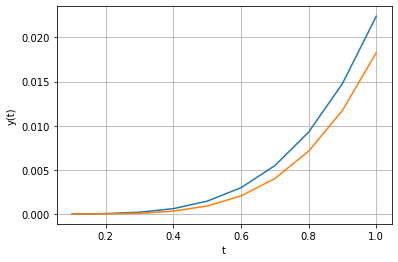

In [ ]:
plt.figure()
plt.plot(t,y_exacta(t, alpha, beta))
plt.plot(t,y_num)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.grid('on')
plt.axis('tight')
plt.show()

## Creación de la Tabla 3.4 de la página 111 del libro de Li y Zeng (2015)

In [ ]:
alpha = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
Delta_t = np.array([10, 20, 40, 80, 160, 320, 640])

table = np.zeros( (len(Delta_t), len(alpha)) )


for f in prange(len(Delta_t)):
    for c in prange(len(alpha)):
        t, y_num = forward_Euler_method(y0, 1/Delta_t[f], tfin, alpha[c], beta)
        
        error_absoluto = np.abs(y_exacta(t, alpha[c], beta) - y_num)
        ultimo_error = error_absoluto[-1]
        table[f,c] = ultimo_error

In [ ]:
pd.DataFrame(table, columns = alpha, index = Delta_t)

,0.1,0.3,0.5,0.7,0.9
10,0.004121,0.004140,0.004282,0.004557,0.004939
20,0.002019,0.001979,0.002051,0.002221,0.002455
40,0.000986,0.000946,0.000989,0.001089,0.001222
80,0.000481,0.000454,0.000480,0.000537,0.000609
160,0.000234,0.000219,0.000235,0.000266,0.000304
320,0.000114,0.000106,0.000116,0.000132,0.000152
640,0.000056,0.000052,0.000057,0.000066,0.000076


# Referencias
* Li, C., & Zeng, F. (2015). *Numerical methods for fractional calculus* (Vol. 24). CRC Press.